# Fine tuning using BERT Large Uncased

### Supress warnings

In [15]:
import warnings
warnings.filterwarnings("ignore")

### Inspect the base model

In [16]:
import os
import torch
from transformers import AutoModelForSequenceClassification

model_name = "bert-large-uncased"
checkpoint = "google-bert/"+model_name

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              31,254,528
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,050
Total params:

In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

### Load the news dataset from pickle file
If any of the check_files don't exist then load the pickle file

In [17]:
import pickle

base_path = './data/'
os.makedirs(base_path, exist_ok=True)

file_name = 'news_small_dataset.pkl'
file_path = base_path+file_name

def pickle_dataset(dataset, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(dataset, file)
        print(f"Dataset has been pickled to: {file_path}")

def load_pickle_dataset(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
        print(f"Dataset has been loaded from: {file_path}")
    return dataset

def check_files_exists(file_names):
    for name in file_names:
        file_path = os.path.join(base_path, name)
        if os.path.exists(file_path):
            return True
    return False

# if these files exist we do not want to load the news_dataset.pkl to tokenize and make these files
check_files = [model_name+'-small_tokenized_train_ds.pkl', model_name+'-small_tokenized_eval_ds.pkl', model_name+'-small_tokenized_test_ds.pkl']

if check_files_exists(check_files):
    print("At least one of the specified files already exists. Not loading new dataset.")
else:
    news_split_ds = load_pickle_dataset(file_path)
    print(news_split_ds)
    total_rows = (news_split_ds['train'].num_rows +
              news_split_ds['eval'].num_rows +
              news_split_ds['test'].num_rows)
    print("Total number of rows:", total_rows)
    print("Dataset loaded successfully.")

At least one of the specified files already exists. Not loading new dataset.


In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(news):
  return tokenizer(news['article'], padding=True, truncation=True, return_tensors="pt", max_length=512)

### Tokenize train, evaluation, and test datasets
If any of the check files exist then don't run tokenization and save some time.
Else load the pickle files that already exist.

In [19]:
if not check_files_exists(check_files):
    tokenized_train_ds = news_split_ds['train'].map(tokenize_fn, batched=True)
    tokenized_eval_ds = news_split_ds['eval'].map(tokenize_fn, batched=True)
    tokenized_test_ds = news_split_ds['test'].map(tokenize_fn, batched=True)

    print(tokenized_train_ds.features)
    print(tokenized_eval_ds.features)
    print(tokenized_test_ds.features)
    
    pickle_dataset(tokenized_train_ds, base_path+model_name+'-small_tokenized_train_ds.pkl')
    pickle_dataset(tokenized_eval_ds, base_path+model_name+'-small_tokenized_eval_ds.pkl')
    pickle_dataset(tokenized_test_ds, base_path+model_name+'-small_tokenized_test_ds.pkl')
else:
    print("Files already exist, so load datasets")
    tokenized_train_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_train_ds.pkl')
    tokenized_eval_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_eval_ds.pkl')
    tokenized_test_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_test_ds.pkl')

Files already exist, so load datasets
Dataset has been loaded from: ./data/bert-large-uncased-small_tokenized_train_ds.pkl
Dataset has been loaded from: ./data/bert-large-uncased-small_tokenized_eval_ds.pkl
Dataset has been loaded from: ./data/bert-large-uncased-small_tokenized_test_ds.pkl


### Look at the tokenized data
Notice what the actual data looks like, and then the tokenized data which is a bunch of numbers, and then the attention mask at the end.

In [8]:
count_train_records = len(tokenized_train_ds)
count_eval_records = len(tokenized_eval_ds)
count_test_records = len(tokenized_test_ds)
print(f"Number of records in training dataset: {count_train_records}")
print(f"Number of records in evaluation dataset: {count_eval_records}")
print(f"Number of records in test dataset: {count_test_records}")
count_total_records = count_train_records + count_eval_records + count_test_records
print(f"Total number of records: {count_total_records}")

Number of records in training dataset: 33611
Number of records in evaluation dataset: 7203
Number of records in test dataset: 7203
Total number of records: 48017


In [9]:
first_record = tokenized_train_ds[0]
print(first_record)

{'article': "In a year where homicides, rapes and robberies increased slightly, New York City still saw serious crime drop 1.7 percent in 2015, continuing an overall decline that began in the 1990s, NYPD Commissioner William Bratton said Monday.\nAt a news conference with Mayor Bill de Blasio, Bratton touted last year’s crime statistics, which he said, when combined with an even larger decline in 2014, put to rest the fear that substantial decreases couldn’t continue under the new administration at City Hall.\n“While we have had some fluctuation, some increases in certain categories, the overall trend in all our crime categories continues to go down,” Bratton told reporters. “It was a very good year for us, 2015.\nHomicides increased by 4.5 percent in 2015, rising to 350 from 333 in the prior year, which was the lowest since 1994, said Deputy Commissioner Dermot Shea. Rapes increased 6 percent and robberies rose 2 percent, said Shea, who is in charge of data collection and operations f

### Turn on accelerate

In [20]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### Look at hardware

In [7]:
print(f"Available GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Available GPUs: 7
GPU 0: NVIDIA GeForce RTX 4090
GPU 1: NVIDIA GeForce RTX 4090
GPU 2: NVIDIA GeForce RTX 4090
GPU 3: NVIDIA GeForce RTX 3090 Ti
GPU 4: NVIDIA GeForce RTX 3090 Ti
GPU 5: NVIDIA GeForce RTX 3090
GPU 6: NVIDIA GeForce RTX 3090


In [12]:
!nvidia-smi

Wed May 22 09:55:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 31%   34C    P8             36W /  420W |      13MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [22]:
project_name = "praxis-"+model_name+"-small-finetune"
output_dir_path = "./" + project_name
output_dir_path

'./praxis-bert-large-uncased-small-finetune'

In [15]:
import torch
torch.cuda.empty_cache()

### Training

In [16]:
import transformers

transformers.set_seed(777)

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    tokenizer=tokenizer,

    args=transformers.TrainingArguments(
        output_dir=output_dir_path,
        num_train_epochs=10,
        logging_steps=10,
        logging_dir=output_dir_path+"/logs",
        evaluation_strategy='epoch',
        save_strategy='epoch',
        bf16=True,
        optim="paged_adamw_8bit",
        do_eval=True,
    ),
    compute_metrics=compute_metrics,
    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=None),
)

model.config.use_cache = False
model = accelerator.prepare_model(model)
trainer.train(resume_from_checkpoint=False)  # Turn to True if power goes out...

2024-05-22 09:56:00.328107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 09:56:00.864924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Currently logged in as: nispoe. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.393100,0.360599,0.843815,0.832579
2,0.289400,0.298993,0.874636,0.864003
3,0.133400,0.354863,0.871859,0.868087
4,0.097600,0.389370,0.879495,0.875366
5,0.022500,0.572214,0.880050,0.873018
6,0.024900,0.563661,0.889768,0.883994
7,0.055900,0.674912,0.890462,0.883184
8,0.006900,0.788489,0.890462,0.885028
9,0.017400,0.831780,0.895183,0.890066
10,0.000000,0.814673,0.896016,0.889461


TrainOutput(global_step=6010, training_loss=0.12112291483948481, metrics={'train_runtime': 9428.0936, 'train_samples_per_second': 35.65, 'train_steps_per_second': 0.637, 'total_flos': 3.132314505281741e+17, 'train_loss': 0.12112291483948481, 'epoch': 10.0})

### Determine best checkpoint

In [17]:
!ls -ltr {output_dir_path}

total 44
drwxr-xr-x 2 nispoe nispoe 4096 May 22 09:56 logs
drwxrwxr-x 2 nispoe nispoe 4096 May 22 10:11 checkpoint-601
drwxrwxr-x 2 nispoe nispoe 4096 May 22 10:27 checkpoint-1202
drwxrwxr-x 2 nispoe nispoe 4096 May 22 10:43 checkpoint-1803
drwxrwxr-x 2 nispoe nispoe 4096 May 22 10:58 checkpoint-2404
drwxrwxr-x 2 nispoe nispoe 4096 May 22 11:14 checkpoint-3005
drwxrwxr-x 2 nispoe nispoe 4096 May 22 11:30 checkpoint-3606
drwxrwxr-x 2 nispoe nispoe 4096 May 22 11:46 checkpoint-4207
drwxrwxr-x 2 nispoe nispoe 4096 May 22 12:01 checkpoint-4808
drwxrwxr-x 2 nispoe nispoe 4096 May 22 12:17 checkpoint-5409
drwxrwxr-x 2 nispoe nispoe 4096 May 22 12:33 checkpoint-6010


In [23]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import glob
import os

# Construct the logs directory path
logs_directory = os.path.join('./', project_name, 'logs')
file_pattern = 'events.out.tfevents.*'

# Retrieve all event files matching the pattern
event_files = glob.glob(os.path.join(logs_directory, file_pattern))

# Function to print out TensorBoard event logs
def print_events_from_file(event_files):
    for event_file in event_files:
        print(f"Reading events from file: {event_file}")
        try:
            for e in summary_iterator(event_file):
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        print(f"Step: {e.step}, {v.tag}: {v.simple_value}")
        except Exception as e:  # Just in case the event file is not readable
            print(f"Failed to read {event_file}: {e}")

print_events_from_file(event_files)

Reading events from file: ./praxis-bert-large-uncased-small-finetune/logs/events.out.tfevents.1716389762.hephaestus.2595688.0
Step: 10, train/loss: 0.6819000244140625
Step: 10, train/grad_norm: 3.657686710357666
Step: 10, train/learning_rate: 4.9916805437533185e-05
Step: 10, train/epoch: 0.01663893461227417
Step: 20, train/loss: 0.6589999794960022
Step: 20, train/grad_norm: 2.169076681137085
Step: 20, train/learning_rate: 4.983361213817261e-05
Step: 20, train/epoch: 0.03327786922454834
Step: 30, train/loss: 0.6484000086784363
Step: 30, train/grad_norm: 3.6420397758483887
Step: 30, train/learning_rate: 4.975041520083323e-05
Step: 30, train/epoch: 0.04991680383682251
Step: 40, train/loss: 0.6299999952316284
Step: 40, train/grad_norm: 4.6052656173706055
Step: 40, train/learning_rate: 4.966722190147266e-05
Step: 40, train/epoch: 0.06655573844909668
Step: 50, train/loss: 0.641700029373169
Step: 50, train/grad_norm: 6.3665618896484375
Step: 50, train/learning_rate: 4.958402496413328e-05
Step

In [24]:
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

logs_directory = os.path.join('./', project_name, 'logs')
file_pattern = 'events.out.tfevents.*'

event_files = glob.glob(os.path.join(logs_directory, file_pattern))

def extract_metrics(event_files):
    data = []
    last_train_loss = None

    for event_file in event_files:
        for e in summary_iterator(event_file):
            for v in e.summary.value:
                if v.HasField('simple_value'):
                    step = e.step
                    metric_name = v.tag.split('/')[-1]
                    metric_value = v.simple_value

                    formatted_value = f"{metric_value:.6f}"

                    if 'train/loss' in v.tag:
                        last_train_loss = formatted_value

                    if 'eval' in v.tag:
                        entry = next((item for item in data if item['Step'] == step), None)
                        if not entry:
                            entry = {'Step': step, 'Train Loss': last_train_loss, 'Eval Loss': None, 'Accuracy': None, 'F1': None}
                            data.append(entry)
                        if 'loss' in v.tag:
                            entry['Eval Loss'] = formatted_value
                        elif 'accuracy' in v.tag:
                            entry['Accuracy'] = formatted_value
                        elif 'f1' in v.tag:
                            entry['F1'] = formatted_value
    return data

metrics_data = extract_metrics(event_files)

df = pd.DataFrame(metrics_data)
df = df.sort_values(by='Step')

file_path = "../images/"+model_name+"_Checkpoint_Data.csv"
df.to_csv(file_path, index=False)

print(df)

   Step Train Loss Eval Loss  Accuracy        F1
0   601   0.393100  0.360599  0.843815  0.832579
1  1202   0.289400  0.298993  0.874636  0.864003
2  1803   0.133400  0.354863  0.871859  0.868087
3  2404   0.097600  0.389370  0.879495  0.875366
4  3005   0.022500  0.572214  0.880050  0.873018
5  3606   0.024900  0.563661  0.889768  0.883994
6  4207   0.055900  0.674912  0.890462  0.883184
7  4808   0.006900  0.788489  0.890462  0.885028
8  5409   0.017400  0.831780  0.895183  0.890066
9  6010   0.000000  0.814673  0.896016  0.889461


In [25]:
df.fillna({
    'Eval Loss': float('inf'),
    'Accuracy': 0,
    'F1': 0
}, inplace=True)

df['Eval Loss'] = df['Eval Loss'].astype(float)
df['Accuracy'] = df['Accuracy'].astype(float)
df['F1'] = df['F1'].astype(float)

df['Eval Loss Rank'] = df['Eval Loss'].rank(method='min', ascending=True)
df['Accuracy Rank'] = df['Accuracy'].rank(method='min', ascending=False)
df['F1 Rank'] = df['F1'].rank(method='min', ascending=False)

df['Rank Sum'] = df['Eval Loss Rank'] + df['Accuracy Rank'] + df['F1 Rank']

best_checkpoint = df.loc[df['Rank Sum'].idxmin()]

checkpoint_folder_name = f"checkpoint-{best_checkpoint['Step']}"
print(f"Best Checkpoint Step: {checkpoint_folder_name}")
print(best_checkpoint[['Step', 'Train Loss', 'Eval Loss', 'Accuracy', 'F1', 'Rank Sum']])

Best Checkpoint Step: checkpoint-6010
Step              6010
Train Loss    0.000000
Eval Loss     0.814673
Accuracy      0.896016
F1            0.889461
Rank Sum          12.0
Name: 9, dtype: object


### Run TensorBoard
tensorboard --logdir=~/kuk/Praxis/praxis-Llama-2-7b-hf-small-finetune/logs --host=0.0.0.0

### PAUSE SCRIPT

In [21]:
# My flag to pause the script, set to True to pause
pause_script = False

In [22]:
class StopExecution(Exception):
    def _render_traceback_(self):
        print("Script Paused")
        pass

In [23]:
if pause_script:
    raise StopExecution

### Testing

In [24]:
from accelerate import Accelerator
from transformers import pipeline

accelerator = Accelerator()

test_checkpoint_name = checkpoint_folder_name
savedmodel = pipeline('text-classification', model=output_dir_path + "/" + test_checkpoint_name, device=accelerator.device)

In [25]:
tokenized_test_ds

Dataset({
    features: ['article', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7203
})

In [26]:
from tqdm.auto import tqdm

max_tokens = 512
truncated_articles = []

for article in tqdm(tokenized_test_ds['article']):
    encoded_article = tokenizer.encode(
        article,
        max_length=max_tokens,
        truncation=True,
        add_special_tokens=True
    )
    truncated_article = tokenizer.decode(encoded_article, skip_special_tokens=True)
    truncated_articles.append(truncated_article)

  0%|          | 0/7203 [00:00<?, ?it/s]

In [27]:
from datasets import Dataset

# Create a dataset from the truncated articles
data = {"text": truncated_articles}
dataset = Dataset.from_dict(data)

# Define a function to make predictions
def classify_batch(batch):
    return savedmodel(batch["text"])

# Process the dataset with batching
test_predictions = []
for batch in tqdm(dataset.to_dict()["text"], desc="Classifying articles"):
    predictions = classify_batch({"text": batch})
    test_predictions.extend(predictions)

test_predictions_labels = []
for prediction in tqdm(test_predictions, desc="Labeling articles"):
    label = 0 if prediction['label'] == 'LABEL_0' else 1
    test_predictions_labels.append(label)

print(test_predictions_labels)

Classifying articles:   0%|          | 0/7203 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Labeling articles:   0%|          | 0/7203 [00:00<?, ?it/s]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 

In [28]:
true_articles = tokenized_test_ds['label']
print(true_articles)

[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

In [29]:
def get_label(prediction):
  return int(prediction['label'].split('_')[1])

processed_predictions = [get_label(prediction) for prediction in test_predictions]

<h1>Accuracy and F1</h1>

In [30]:
true_articles = tokenized_test_ds['label']
accuracy = accuracy_score(true_articles, test_predictions_labels)
print("accuracy:", accuracy)

accuracy: 0.8994863251423019


<p>precision (how many of the items identified as positive are actually positive) and the recall (how many of the actual positives were identified correctly)</p>

In [31]:
from sklearn.metrics import f1_score
f1 = f1_score(true_articles, test_predictions_labels, average='macro')
print("f1_score:", f1)

f1_score: 0.8931581513700004


<h1>Confusion Matrix</h1>

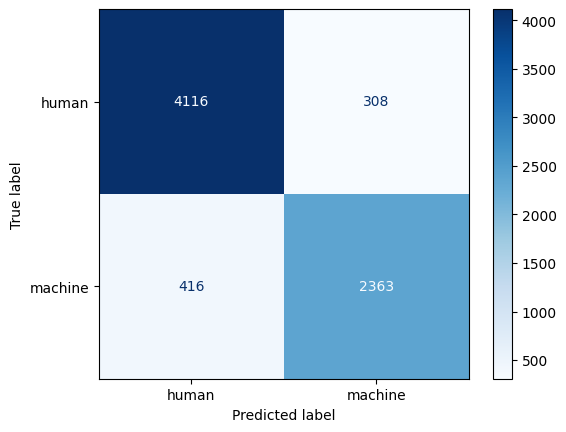

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(tokenized_test_ds['label'], processed_predictions)

labels = ['human', 'machine']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
file_name = f"{project_name}.ipynb"
html_file_name = f"{file_name.replace('.ipynb', '.html')}"

command = f"jupyter nbconvert '{file_name}' --to html --output-dir './html' --output '{html_file_name}'"
get_ipython().system(command)

[NbConvertApp] Converting notebook praxis-bert-large-uncased-small-finetune-v7.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 575666 bytes to html/praxis-bert-large-uncased-small-finetune-v7.html
